# Project 3: Battery Equivalent Circuit Model Design
>**Date Created**: 19 February 2024<br>
>**Course**: AEM566 - Optimal Estimation<br>
>**Author**: Benjamin Lucke<br>

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt
from scipy.integrate import trapezoid, simpson
from scipy.optimize import least_squares
from scipy.integrate import quad

plt.rcParams["text.usetex"] = True

### 1. Load the battery data for the pulse discharge tests in the accompanying CSV file

In [2]:
data = pd.read_csv("data/pulse_discharge_test_data.csv")
# rename columns to make easier to reference and convert times to datetime for convenience
columnMapper = dict(
    zip(
        data.columns.values,
        ["t", "v", "i"],
    )
)
data = data.rename(columns=columnMapper)
data["t"] = pd.to_datetime(data["t"], format="%H:%M:%S")

### 2. Numerically integrate the current to obtain the SOC for the entire data set

In [3]:
Q = simpson(y=data["i"], x=data.index[:])

### 3. Partition the data into each rest period using the current measurement as the trigger

Text(0, 0.5, 'Current (amperes)')

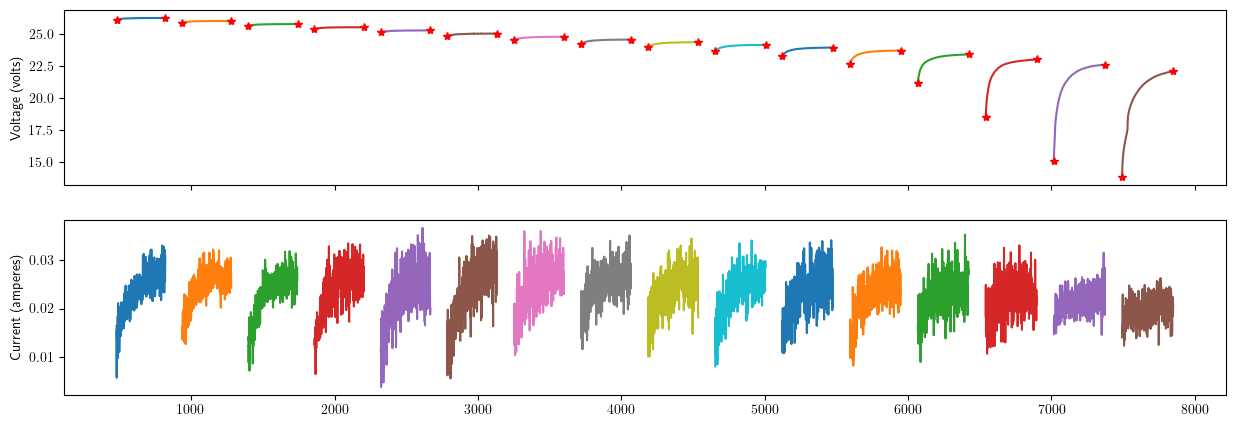

In [4]:
data["i_diff"] = data.loc[:, "i"].diff()
delta_indices = data[
    (data["i_diff"]) > 0.1
].index.tolist()  # Get indices based on differnetial in current
pairs = list()

# Create grouped pairs of indices where rest period starts and ends
for k, index in enumerate(delta_indices):
    if k == len(delta_indices) - 1:
        pair = (
            index + 118,
            data.index[-1],
        )  # +118 was by trial and error, gave consistently ok results of rest period indices
    else:
        pair = index + 118, delta_indices[k + 1]
    pairs.append(pair)
pairs = np.array(pairs)
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 5), sharex=True)
for k, (start, end) in enumerate(pairs):
    ax1.plot(data.iloc[start:end, 1])
    ax2.plot(data.iloc[start:end, 2])
    ax1.plot(start, data.iloc[start, 1], "r*")
    ax1.plot(end, data.iloc[start:end, 1].iloc[-1], "r*")
ax1.set_ylabel("Voltage (volts)")
ax2.set_ylabel("Current (amperes)")

In [5]:
def initial_estimate_r0(rest_start, rest_end):
    """Get initial guess for R0"""
    v_ts = data.iloc[
        rest_start - 1, 1
    ]  # get voltage at time step before rest period starts
    v_tr_0 = data.iloc[rest_start, 1]  # get voltage at start of rest period
    lhs = v_tr_0 - v_ts  # Compute difference in voltages
    r0_est = lhs / data.iloc[rest_start, 2]  # divide by current to get estimate of R0
    return r0_est

In [6]:
def initial_estimate_r1(rest_start, rest_end):
    """Get initial guess for R1"""
    ocv = data.iloc[rest_start:rest_end, 1].iloc[
        -1
    ]  # use voltage at end of rest period as crude estimate to OCV
    v_tr_0 = data.iloc[rest_start, 1]
    i_dis = data.iloc[rest_start, 2]
    i_dis_R1 = 0.95 * (ocv - v_tr_0)  # get quantity i_dis * R_1
    r1_est = (
        0.95 * (ocv - v_tr_0) / i_dis
    )  # divide by i_dis at start of rest period to get estimate of R_1
    return i_dis_R1, r1_est

In [7]:
def initial_estimate_tau1(rest_start, rest_end):
    """Get initial guess for tau_1"""
    rhs, _ = initial_estimate_r1(rest_start, rest_end)
    v_tr_0 = data.iloc[rest_start, 1]

    # Loop through indices between rest period start and end to find first index >= .95*(OCV - V_tr_0)
    for k in range(rest_start, rest_end):
        v_tr_candidate = data.iloc[k, 1]
        result = v_tr_candidate - v_tr_0
        if result >= rhs:
            first_larger_index = k
            break

    v_tr = data.iloc[first_larger_index, 1]
    thrice_tau1 = 10 * (first_larger_index - rest_start)
    tau_1_est = thrice_tau1 / 3
    return tau_1_est

In [8]:
def initial_estimate_ocv(rest_start, rest_end):
    """Get initial guess for OCV"""
    ocv = data.iloc[rest_start:rest_end, 1].iloc[-1]
    return ocv

## Get initial guesses for OCV, $R_0$, $R_1$, and  $\tau_1$

In [9]:
# Using the methods above, get initial guesses for parameters R0, R1, TAU1, OCV, etc.

initial_estimates_single_term = np.zeros((pairs.shape[0], 4))
for k, (start, end) in enumerate(pairs):
    rest_start = start
    rest_end = end
    ocv_est = initial_estimate_ocv(rest_start, rest_end)
    r0_est = initial_estimate_r0(rest_start, rest_end)
    _, r1_est = initial_estimate_r1(rest_start, rest_end)
    tau1_est = initial_estimate_tau1(rest_start, rest_end)
    initial_estimates_single_term[k] = ocv_est, r0_est, r1_est, tau1_est

# Two exponential terms
initial_estimates_two_terms = np.zeros((pairs.shape[0], 6))
for k, (start, end) in enumerate(pairs):
    rest_start = start
    rest_end = end

    ocv_est = initial_estimate_ocv(rest_start, rest_end)
    r0_est = initial_estimate_r0(rest_start, rest_end)
    _, r1_est = initial_estimate_r1(rest_start, rest_end)
    r1_est /= 2  # divide r1 into two parameters, r1 and r2
    r2_est = r1_est

    tau1_est = initial_estimate_tau1(rest_start, rest_end)
    tau2_est = tau1_est / 10

    initial_estimates_two_terms[k] = ocv_est, r0_est, r1_est, r2_est, tau1_est, tau2_est

# Three exponential terms
initial_estimates_three_terms = np.zeros((pairs.shape[0], 8))
for k, (start, end) in enumerate(pairs):
    rest_start = start
    rest_end = end

    ocv_est = initial_estimate_ocv(rest_start, rest_end)
    r0_est = initial_estimate_r0(rest_start, rest_end)
    _, r1_est = initial_estimate_r1(rest_start, rest_end)
    r1_est /= 3  # divide r1 into three parameters, r1 and r2 and r3
    r2_est = r1_est
    r3_est = r2_est

    tau1_est = initial_estimate_tau1(rest_start, rest_end)
    tau2_est = tau1_est / 10
    tau3_est = tau2_est / 10

    initial_estimates_three_terms[k] = (
        ocv_est,
        r0_est,
        r1_est,
        r2_est,
        r3_est,
        tau1_est,
        tau2_est,
        tau3_est,
    )

### Perform Least Squares on Each Rest Period and get Updated Parameters

In [10]:
def y_single(Theta, t):
    OCV = Theta[0]
    R0 = Theta[1]
    R1 = Theta[2]
    tau1 = Theta[3]
    i_ts = data.iloc[t_s, 1]
    vtr = OCV - i_ts * R1 * np.exp(-t / tau1)
    return vtr


def y_double(Theta, t):
    OCV = Theta[0]
    R0 = Theta[1]
    R1 = Theta[2]
    R2 = Theta[3]
    tau1 = Theta[4]
    tau2 = Theta[5]
    i_ts = data.iloc[t_s, 1]
    ntr = -10 * (end - start)
    t_ser = np.arange(0, abs(ntr / 10))

    vtr = OCV - i_ts * R1 * np.exp(-t / tau1) - i_ts * R2 * np.exp(-t / tau2)
    return vtr


def y_triple(Theta, t):
    OCV = Theta[0]
    R0 = Theta[1]
    R1 = Theta[2]
    R2 = Theta[3]
    R3 = Theta[4]
    tau1 = Theta[5]
    tau2 = Theta[6]
    tau3 = Theta[7]
    i_ts = data.iloc[t_s, 1]
    ntr = -10 * (end - start)
    t_ser = np.arange(0, abs(ntr / 10))

    vtr = (
        OCV
        - i_ts * R1 * np.exp(-t / tau1)
        - i_ts * R2 * np.exp(-t / tau2)
        - i_ts * R3 * np.exp(-t / tau3)
    )
    return vtr


def residual_fun(Theta):
    return y_single(Theta, t_series) - ys

In [11]:
# Single exponential term fit
least_squares_params_single = np.zeros(initial_estimates_single_term.shape)
resid_means_single = np.zeros(16)
for k, pair in enumerate(pairs):
    start, end = pair
    t_s = start - 1
    t_series = np.arange(start, end)
    ys = data.iloc[start:end, 1]
    initial_guesses = initial_estimates_single_term[k]
    updated_params = least_squares(residual_fun, initial_guesses)
    resid_means_single[k] = np.mean(updated_params.fun)
    least_squares_params_single[k] = updated_params.x


# # Two exponential terms fit
least_squares_params_two_terms = np.zeros(initial_estimates_two_terms.shape)
resid_means_two_terms = np.zeros(16)
for k, pair in enumerate(pairs):
    start, end = pair
    t_s = start - 1
    t_series = np.arange(start, end)
    ys = data.iloc[start:end, 1]
    initial_guesses = initial_estimates_two_terms[k]
    updated_params = least_squares(residual_fun, initial_guesses)
    resid_means_two_terms[k] = np.mean(updated_params.fun)
    least_squares_params_two_terms[k] = updated_params.x


# # Three exponential terms fit
least_squares_params_three_terms = np.zeros(initial_estimates_three_terms.shape)
resid_means_three_terms = np.zeros(16)
for k, pair in enumerate(pairs):
    start, end = pair
    t_s = start - 1
    t_series = np.arange(start, end)
    ys = data.iloc[start:end, 1]
    initial_guesses = initial_estimates_three_terms[k]
    updated_params = least_squares(residual_fun, initial_guesses)
    resid_means_three_terms[k] = np.mean(updated_params.fun)
    least_squares_params_three_terms[k] = updated_params.x


display(resid_means_single, resid_means_two_terms, resid_means_three_terms)

array([ 2.37933695e-10,  4.37345806e-11,  7.68586309e-11,  1.37780518e-11,
        5.48218525e-06,  9.10012850e-07,  3.15388514e-05, -3.18284412e-07,
        8.63709487e-07,  7.51396904e-07,  3.01856738e-04,  1.32431083e-03,
        3.57296022e-03,  7.58241825e-04,  1.01843345e-02,  2.79987999e-03])

array([ 1.02499492e-06, -1.65091901e-06,  3.71796850e-06,  5.97606640e-07,
       -1.91986832e-06,  4.21175637e-06, -2.81804147e-06,  6.57805098e-07,
        9.35234293e-07,  3.94418700e-06, -2.38301844e-06, -3.70740652e-05,
        8.91729059e-06,  6.53040866e-06, -5.30818374e-10,  1.16730232e-02])

array([ 3.04577428e-07,  2.26469323e-06,  3.13039690e-06,  9.08333894e-08,
       -2.24296788e-06,  3.34513828e-06, -1.70662869e-06,  6.72770684e-07,
        2.51679021e-06, -2.93067917e-07, -3.22344785e-06, -1.83857290e-06,
        6.30062031e-07,  3.21544214e-06,  1.16818758e-06,  1.81542482e-04])

The means of the residuals for each rest period tend to decrease with increase in model complexity.

### Calculate SOC and plot parameters as a function of SOC

In [12]:
SOC = 1
SOC_vals = []
for k, pair in enumerate(pairs):
    if k == 0:
        discharge = simpson(y=data.iloc[0 : pair[1], 2], dx=1) / Q
    else:
        discharge = simpson(y=data.iloc[pairs[k - 1][1] : pairs[k][1], 2], dx=1) / Q
    SOC -= discharge
    SOC_vals.append(SOC)
SOC_vals = np.array(SOC_vals) * 100

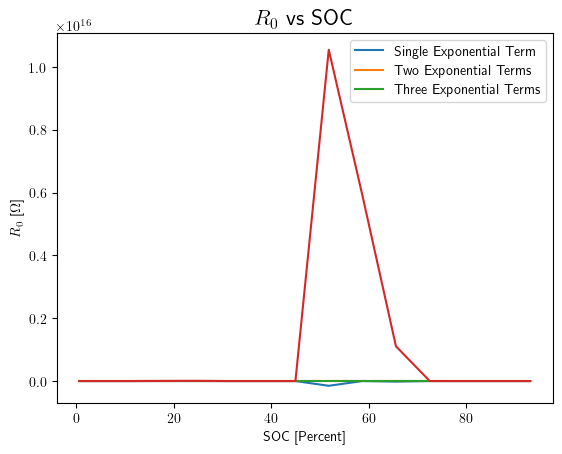

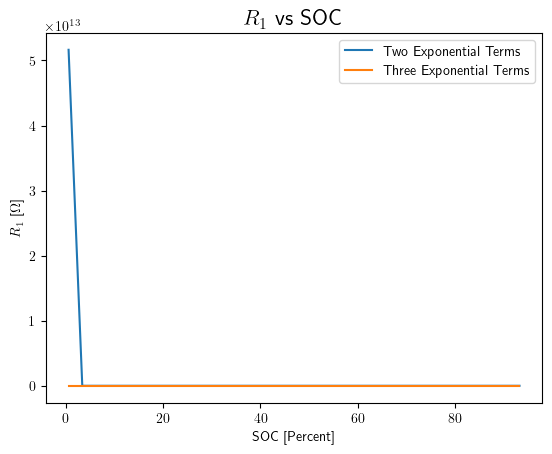

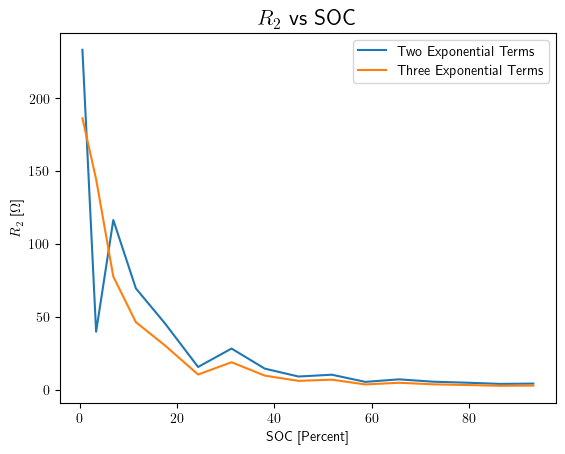

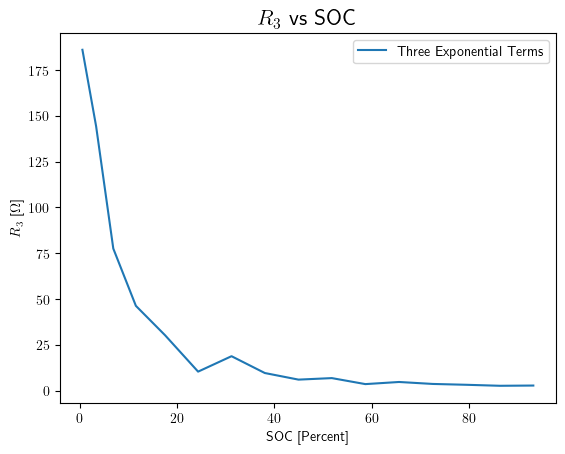

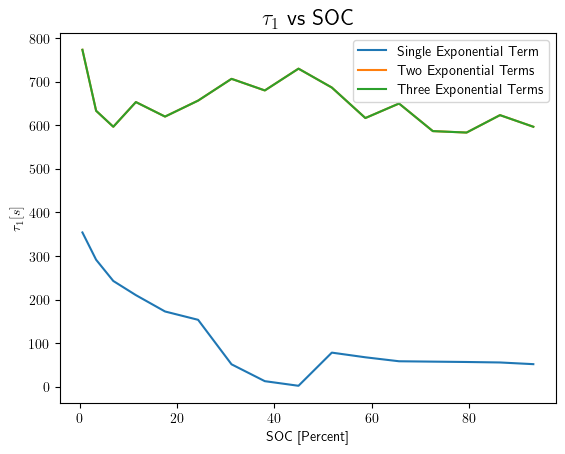

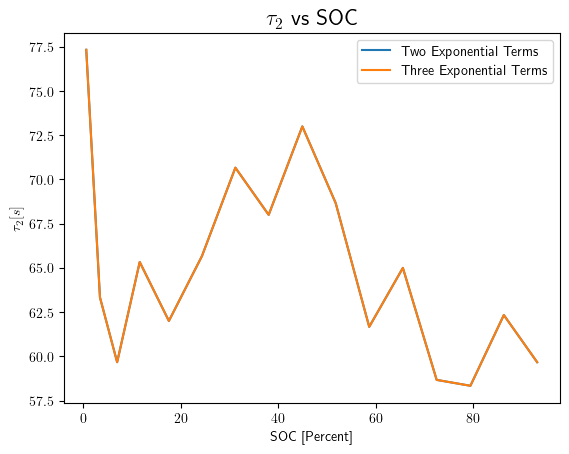

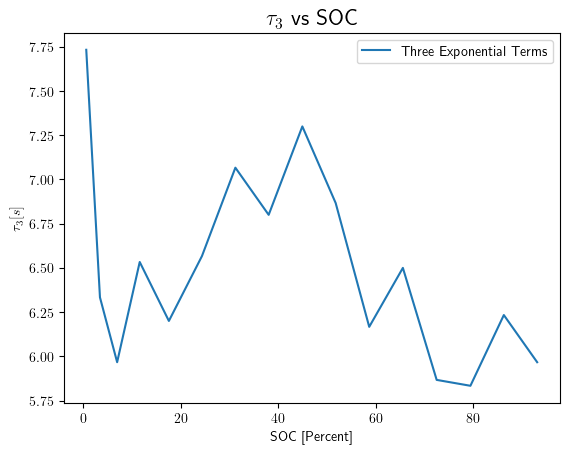

In [13]:
fig, ax1 = plt.subplots()
ax1.plot(SOC_vals, least_squares_params_single[:, 1], label="Single Exponential Term")
ax1.plot(SOC_vals, least_squares_params_two_terms[:, 1], label="Two Exponential Terms")
ax1.plot(
    SOC_vals, least_squares_params_three_terms[:, 1], label="Three Exponential Terms"
)
ax1.set_title("$R_0$ vs SOC", fontsize=16)
ax1.set_xlabel(r"SOC [Percent]")
ax1.set_ylabel("$R_0$ [$\Omega$]")
plt.legend()

fig, ax2 = plt.subplots()
ax1.plot(SOC_vals, least_squares_params_single[:, 2], label="Single Exponential Term")
ax2.plot(SOC_vals, least_squares_params_two_terms[:, 2], label="Two Exponential Terms")
ax2.plot(
    SOC_vals, least_squares_params_three_terms[:, 2], label="Three Exponential Terms"
)
ax2.set_title("$R_1$ vs SOC", fontsize=16)
ax2.set_xlabel(r"SOC [Percent]")
ax2.set_ylabel("$R_1$ [$\Omega$]")
plt.legend()


fig, ax3 = plt.subplots()
ax3.plot(SOC_vals, least_squares_params_two_terms[:, 3], label="Two Exponential Terms")
ax3.plot(
    SOC_vals, least_squares_params_three_terms[:, 3], label="Three Exponential Terms"
)
ax3.set_title("$R_2$ vs SOC", fontsize=16)
ax3.set_xlabel(r"SOC [Percent]")
ax3.set_ylabel("$R_2$ [$\Omega$]")
plt.legend()

fig, ax4 = plt.subplots()
ax4.plot(
    SOC_vals, least_squares_params_three_terms[:, 4], label="Three Exponential Terms"
)
ax4.set_title("$R_3$ vs SOC", fontsize=16)
ax4.set_xlabel(r"SOC [Percent]")
ax4.set_ylabel("$R_3$ [$\Omega$]")
plt.legend()

fig, ax5 = plt.subplots()
ax5.plot(SOC_vals, least_squares_params_single[:, 3], label="Single Exponential Term")
ax5.plot(SOC_vals, least_squares_params_two_terms[:, 4], label="Two Exponential Terms")
ax5.plot(
    SOC_vals, least_squares_params_three_terms[:, 5], label="Three Exponential Terms"
)
ax5.set_title(r"$\tau_1$ vs SOC", fontsize=16)
ax5.set_xlabel(r"SOC [Percent]")
ax5.set_ylabel(r"$\tau_1 [s]$")
plt.legend()

fig, ax6 = plt.subplots()

ax6.plot(SOC_vals, least_squares_params_two_terms[:, 5], label="Two Exponential Terms")
ax6.plot(
    SOC_vals, least_squares_params_three_terms[:, 6], label="Three Exponential Terms"
)
ax6.set_title(r"$\tau_2$ vs SOC", fontsize=16)
ax6.set_xlabel(r"SOC [Percent]")
ax6.set_ylabel(r"$\tau_2 [s]$")
plt.legend()

fig, ax7 = plt.subplots()
ax7.plot(
    SOC_vals, least_squares_params_three_terms[:, 7], label="Three Exponential Terms"
)
ax7.set_title(r"$\tau_3$ vs SOC", fontsize=16)
ax7.set_xlabel(r"SOC [Percent]")
ax7.set_ylabel(r"$\tau_3 [s]$")
plt.legend()

As RC elements are added, the spikes in the residuals and the reuslting values are generally less severe. 

### Plot SOC

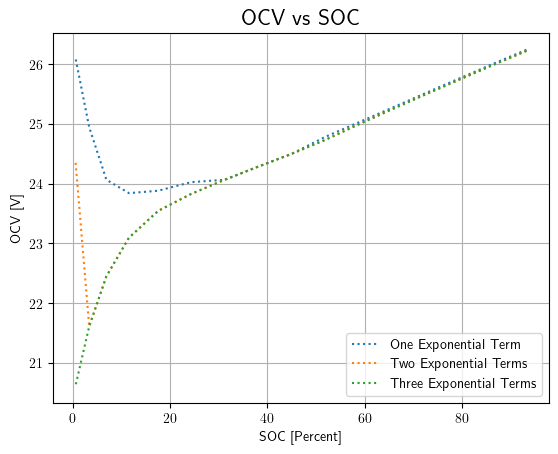

In [14]:
fig, ax7 = plt.subplots()
ax7.plot(
    SOC_vals,
    least_squares_params_single[:, 0],
    label="One Exponential Term",
    linestyle=":",
)
ax7.plot(
    SOC_vals,
    least_squares_params_two_terms[:, 0],
    label="Two Exponential Terms",
    linestyle=":",
)
ax7.plot(
    SOC_vals,
    least_squares_params_three_terms[:, 0],
    label="Three Exponential Terms",
    linestyle=":",
)
ax7.set_title(r"OCV vs SOC", fontsize=16)
ax7.set_xlabel(r"SOC [Percent]")
ax7.set_ylabel(r"OCV [V]")
plt.legend()
plt.grid()